<a href="https://colab.research.google.com/github/del-luna/aiffel/blob/main/Going_deeper_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRPN4QR/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRPN4QR/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [3]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [4]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

In [5]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

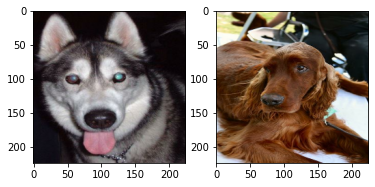

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [7]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [8]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [9]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [10]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [11]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [12]:
# Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 10

In [13]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 174s 206ms/step - loss: 2.1997 - accuracy: 0.4396 - val_loss: 3.6428 - val_accuracy: 0.1664
Epoch 2/10
750/750 [==============================] - 173s 231ms/step - loss: 0.7505 - accuracy: 0.7933 - val_loss: 1.0982 - val_accuracy: 0.6764
Epoch 3/10
750/750 [==============================] - 160s 214ms/step - loss: 0.2332 - accuracy: 0.9524 - val_loss: 0.9452 - val_accuracy: 0.7231
Epoch 4/10
750/750 [==============================] - 173s 231ms/step - loss: 0.0619 - accuracy: 0.9936 - val_loss: 0.9072 - val_accuracy: 0.7408
Epoch 5/10
750/750 [==============================] - 174s 232ms/step - loss: 0.0429 - accuracy: 0.9969 - val_loss: 0.9149 - val_accuracy: 0.7425
Epoch 6/10
750/750 [==============================] - 160s 213ms/step - loss: 0.0170 - accuracy: 0.9992 - val_loss: 0.9452 - val_accuracy: 0.7390
Epoch 7/10
750/750 [==============================] - 160s 213ms/step - loss: 0.0146 - accuracy: 0.9995 - val_loss: 0.9378 - val_accura

In [14]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 183s 232ms/step - loss: 2.3111 - accuracy: 0.4194 - val_loss: 2.6257 - val_accuracy: 0.3229
Epoch 2/10
750/750 [==============================] - 160s 214ms/step - loss: 0.9815 - accuracy: 0.7161 - val_loss: 1.0489 - val_accuracy: 0.6865
Epoch 3/10
750/750 [==============================] - 173s 231ms/step - loss: 0.5515 - accuracy: 0.8464 - val_loss: 1.0548 - val_accuracy: 0.6895
Epoch 4/10
750/750 [==============================] - 160s 214ms/step - loss: 0.2826 - accuracy: 0.9327 - val_loss: 1.0568 - val_accuracy: 0.6972
Epoch 5/10
750/750 [==============================] - 160s 213ms/step - loss: 0.2086 - accuracy: 0.9520 - val_loss: 1.1319 - val_accuracy: 0.6817
Epoch 6/10
750/750 [==============================] - 160s 214ms/step - loss: 0.0970 - accuracy: 0.9834 - val_loss: 1.0017 - val_accuracy: 0.7269
Epoch 7/10
750/750 [==============================] - 173s 231ms/step - loss: 0.0788 - accuracy: 0.9868 - val_loss: 1.0010 - val_accura

In [15]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = cutmix_resnet50.fit(
    ds_train_aug_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 170s 214ms/step - loss: 3.8354 - accuracy: 0.2108 - val_loss: 3.3504 - val_accuracy: 0.2174
Epoch 2/10
750/750 [==============================] - 160s 213ms/step - loss: 3.0330 - accuracy: 0.4073 - val_loss: 1.4490 - val_accuracy: 0.5893
Epoch 3/10
750/750 [==============================] - 173s 231ms/step - loss: 2.7720 - accuracy: 0.4823 - val_loss: 1.2396 - val_accuracy: 0.6486
Epoch 4/10
750/750 [==============================] - 160s 214ms/step - loss: 2.5806 - accuracy: 0.5497 - val_loss: 1.3390 - val_accuracy: 0.6342
Epoch 5/10
750/750 [==============================] - 173s 231ms/step - loss: 2.4790 - accuracy: 0.5762 - val_loss: 1.4412 - val_accuracy: 0.6140
Epoch 6/10
750/750 [==============================] - 160s 214ms/step - loss: 2.3335 - accuracy: 0.6176 - val_loss: 1.1438 - val_accuracy: 0.6845
Epoch 7/10
750/750 [==============================] - 160s 213ms/step - loss: 2.2347 - accuracy: 0.6491 - val_loss: 1.4051 - val_accura

In [16]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = mixup_resnet50.fit(
    ds_train_aug_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 170s 214ms/step - loss: 3.7558 - accuracy: 0.2267 - val_loss: 3.5919 - val_accuracy: 0.1781
Epoch 2/10
750/750 [==============================] - 160s 213ms/step - loss: 2.9457 - accuracy: 0.4458 - val_loss: 1.4347 - val_accuracy: 0.5981
Epoch 3/10
750/750 [==============================] - 160s 214ms/step - loss: 2.7107 - accuracy: 0.5260 - val_loss: 1.3900 - val_accuracy: 0.6174
Epoch 4/10
750/750 [==============================] - 173s 231ms/step - loss: 2.5334 - accuracy: 0.5938 - val_loss: 1.3446 - val_accuracy: 0.6314
Epoch 5/10
750/750 [==============================] - 161s 214ms/step - loss: 2.3887 - accuracy: 0.6477 - val_loss: 1.4717 - val_accuracy: 0.6047
Epoch 6/10
750/750 [==============================] - 160s 213ms/step - loss: 2.3119 - accuracy: 0.6770 - val_loss: 1.1642 - val_accuracy: 0.6800
Epoch 7/10
750/750 [==============================] - 160s 214ms/step - loss: 2.2274 - accuracy: 0.7144 - val_loss: 1.4189 - val_accura

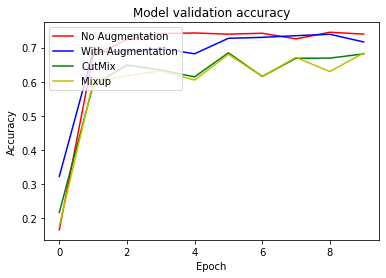

In [17]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.show()

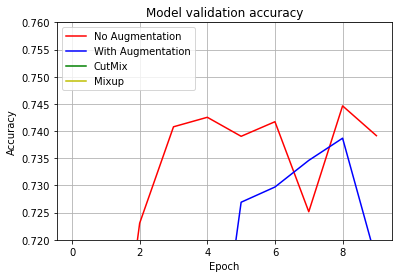

In [18]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당
plt.show()